# Diabetic Retinopathy Detection using Vision Transformer (ViT)

*This part focuses on the detection of diabetic retinopathy using the Vision Transformer (ViT) model. By harnessing the power of deep learning and computer vision, the system automates the process of detecting this eye disease using 3 classes as disease levels. The ViT model is trained on a dataset of retinal images found on Kaggel at this link: https://www.kaggle.com/datasets/amanneo/diabetic-retinopathy-resized-arranged*

*In order to learn complex patterns associated with diabetic retinopathy. Other machine learning techniques, such as data normalisation and optimisation algorithms, are used to improve accuracy. The aim is to create an effective and scalable solution that helps healthcare professionals make timely diagnoses to improve patient outcomes.*

## Data exploration and pre-processing

*Installing Transformers Library and Accelerating Datasets*


In [1]:
!pip install transformers
!pip install datasets accelerate>=0.20.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 68.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 97.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.8 MB/s eta 0:00:00


*Importing Libraries and Dependencies for Data Processing and Analysis*

In [2]:
import zipfile
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import shutil
from datasets import load_dataset
import torch
import torch.nn as nn
from transformers import ViTModel
import numpy as np
import torch
import cv2
import torch.nn as nn
from transformers import ViTModel, ViTConfig
from torchvision import transforms
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import tqdm

*Setting Up Kaggle and Downloading Diabetic Retinopathy Dataset*

In [3]:
!pip install kaggle
!mkdir ~/.kaggle
!cp /content/kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d amanneo/diabetic-retinopathy-resized-arranged

# Open the zip file
with zipfile.ZipFile("/content/diabetic-retinopathy-resized-arranged.zip", "r") as zip_ref:
    # Extract all contents of the zip file to the current working directory
    zip_ref.extractall()

 99% 1.20G/1.21G [00:14<00:00, 118MB/s]
100% 1.21G/1.21G [00:14<00:00, 90.1MB/s]


*Creating DataFrame for Diabetic Retinopathy Image Pairs*

In [4]:
map = lambda x: 0 if x == 0 else (1 if (x == 1 or x == 2) else (2 if (x == 3 or x == 4) else 4))

le = ["/content/"+str(i) + "/" + left for i in range(5) for left in os.listdir("/content/"+str(i)) if left.endswith("_left.jpeg")]
ri = ["/content/"+str(i) + "/" + right+"@"+str(map(i)) for i in range(5) for right in os.listdir("/content/"+str(i)) if right.endswith("_right.jpeg")]

def pairs(le, ri):
  return [[left, right.split("@")[0], right.split("@")[1]] for left in le for right in ri if left.split("_")[0] == right.split("_")[0]]

pi = pairs(le, ri)

df = pd.DataFrame(pi, columns=['leftEye', 'rightEye', 'class'])

df.tail()

,leftEye,rightEye,class
15318,/content/4/2810_left.jpeg,/content/4/2810_right.jpeg,2
15319,/content/4/31729_left.jpeg,/content/4/31729_right.jpeg,2
15320,/content/4/19061_left.jpeg,/content/4/19061_right.jpeg,2
15321,/content/4/41761_left.jpeg,/content/4/41761_right.jpeg,2
15322,/content/4/936_left.jpeg,/content/4/936_right.jpeg,2


*Visualizing Class Distribution of Diabetic Retinopathy Image Pairs*

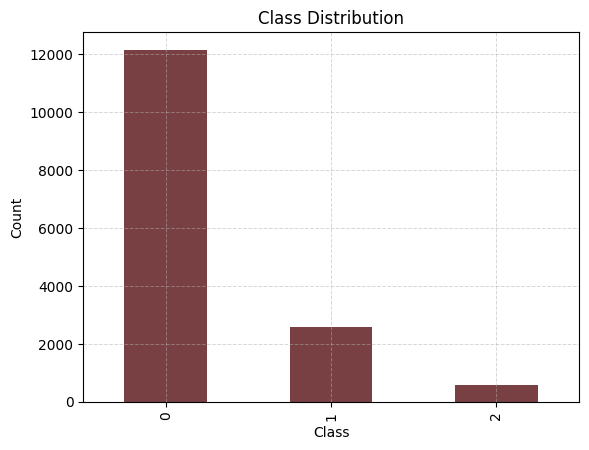

In [5]:
# get the class distribution
class_counts = df['class'].value_counts()

# plot the class distribution
fig, ax = plt.subplots()
class_counts.plot(kind='bar', ax=ax, color="#794044")
ax.grid(True, linestyle='--', linewidth=0.7, alpha=0.5)
ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_title('Class Distribution')
plt.show()

*Balancing Diabetic Retinopathy Image Pairs Dataset*

In [6]:
df = df[:len(df[df['class']=='2'])].append(df[df["class"]=='1'][:len(df[df['class']=='2'])]).append(df[df["class"]=="2"])

<ipython-input-6-e1b97d6c765c>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df[:len(df[df['class']=='2'])].append(df[df["class"]=='1'][:len(df[df['class']=='2'])]).append(df[df["class"]=="2"])
<ipython-input-6-e1b97d6c765c>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df[:len(df[df['class']=='2'])].append(df[df["class"]=='1'][:len(df[df['class']=='2'])]).append(df[df["class"]=="2"])


In [7]:
df[df["class"]=='1'].shape, df[df["class"]=='2'].shape, df[df["class"]=='0'].shape

((570, 3), (570, 3), (570, 3))

In [8]:
df.head(4)

,leftEye,rightEye,class
0,/content/0/16833_left.jpeg,/content/0/16833_right.jpeg,0
1,/content/0/36341_left.jpeg,/content/0/36341_right.jpeg,0
2,/content/0/20109_left.jpeg,/content/0/20109_right.jpeg,0
3,/content/0/7391_left.jpeg,/content/0/7391_right.jpeg,0


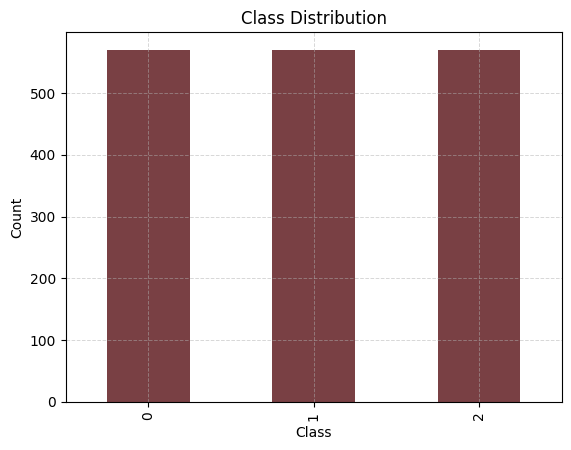

In [9]:
# get the class distribution
class_counts = df['class'].value_counts()

# plot the class distribution
fig, ax = plt.subplots()
class_counts.plot(kind='bar', ax=ax, color="#794044")
ax.grid(True, linestyle='--', linewidth=0.7, alpha=0.5)
ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_title('Class Distribution')
plt.show()

*Organizing Diabetic Retinopathy Image Pairs into Train, Test, and Validation Sets*

In [10]:
def push_data(df, eye):
  data=[df[df['class']=="0"], df[df['class']=="1"], df[df['class']=="2"]]
  if not os.path.exists("./images_"+eye+"/"):
      os.mkdir("./images_"+eye+"/")
      os.mkdir("./images_"+eye+"/train/")
      os.mkdir("./images_"+eye+"/test/")
      os.mkdir("./images_"+eye+"/validation/")
      os.mkdir("./images_"+eye+"/train/0")
      os.mkdir("./images_"+eye+"/test/0")
      os.mkdir("./images_"+eye+"/train/1")
      os.mkdir("./images_"+eye+"/test/1")
      os.mkdir("./images_"+eye+"/train/2")
      os.mkdir("./images_"+eye+"/test/2")
      os.mkdir("./images_"+eye+"/validation/0")
      os.mkdir("./images_"+eye+"/validation/1")
      os.mkdir("./images_"+eye+"/validation/2")
  for item in range(len(data)):
    X_train, X_test, _, yt = train_test_split(data[item][eye], data[item]["class"], test_size=0.2, random_state=42)
    X_test, X_val, _, _ = train_test_split(X_test, yt, test_size=0.4, random_state=42)
    for img in X_train:
      shutil.move(img, "./images_"+eye+f"/train/{str(item)}/")
    for img in X_test:
      shutil.move(img, "./images_"+eye+f"/test/{str(item)}/")
    for img in X_val:
      shutil.move(img, "./images_"+eye+f"/validation/{str(item)}/")

In [11]:
push_data(df, 'rightEye')
push_data(df, 'leftEye')

*Loading and Shuffling Diabetic Retinopathy Image Datasets (Left and Right Eye)*

In [12]:
dataset_left = load_dataset("imagefolder", data_dir="/content/images_leftEye").shuffle()
dataset_right = load_dataset("imagefolder", data_dir="/content/images_rightEye").shuffle()

Resolving data files:   0%|          | 0/1368 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/138 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/204 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-2c44eff59ed1aaa5/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1368 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/138 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/204 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-a0f558378de6d859/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

*Mapping Labels to Indices and Vice Versa for Diabetic Retinopathy Image Dataset*

In [13]:
# Mapping from label to index and vice versa
labels = dataset_left["train"].features["label"].names
num_labels = len(dataset_left["train"].features["label"].names)
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

print(label2id)
print(id2label)

{'0': 0, '1': 1, '2': 2}
{0: '0', 1: '1', 2: '2'}


*Applying Convolutional Projection to Image using ViT*

In [14]:
# Create toy image with dim (batch x channel x width x height)
toy_img = torch.rand(1, 3, 48, 48)

# Define conv layer parameters
num_channels = 3
hidden_size = 768 #or emb_dimension
patch_size = 16

# Conv 2D layer
projection = nn.Conv2d(num_channels, hidden_size, kernel_size=patch_size,
             stride=patch_size)

# Forward pass toy img
out_projection = projection(toy_img)

print(f'Original image size: {toy_img.size()}')
print(f'Size after projection: {out_projection.size()}')

Original image size: torch.Size([1, 3, 48, 48])
Size after projection: torch.Size([1, 768, 3, 3])


In [15]:
# Flatten the output after projection with Conv2D layer
patch_embeddings = out_projection.flatten(2).transpose(1, 2)
print(f'Patch embedding size: {patch_embeddings.size()}')

Patch embedding size: torch.Size([1, 9, 768])


*Prepending [CLS] Token to Patch Embeddings in ViT*

In [16]:
# Define [CLS] token embedding with the same emb dimension as the patches
batch_size = 1
cls_token = nn.Parameter(torch.randn(1, 1, hidden_size))
cls_tokens = cls_token.expand(batch_size, -1, -1)

# Prepend [CLS] token in the beginning of patch embedding
patch_embeddings = torch.cat((cls_tokens, patch_embeddings), dim=1)
print(f'Patch embedding size: {patch_embeddings.size()}')

Patch embedding size: torch.Size([1, 10, 768])


In [17]:
# Define position embedding with the same dimension as the patch embedding
position_embeddings = nn.Parameter(torch.randn(batch_size, 10, hidden_size))

# Add position embedding into patch embedding
input_embeddings = patch_embeddings + position_embeddings
print(f'Input embedding size: {input_embeddings.size()}')

Input embedding size: torch.Size([1, 10, 768])


*Applying Transformer Encoder to Input Embeddings in ViT*

In [18]:
# Define parameters for ViT-base (example)
num_heads = 12
num_layers = 12

# Define Transformer encoders' stack
transformer_encoder_layer = nn.TransformerEncoderLayer(
           d_model=hidden_size, nhead=num_heads,
           dim_feedforward=int(hidden_size * 4),
           dropout=0.1)
transformer_encoder = nn.TransformerEncoder(
           encoder_layer=transformer_encoder_layer,
           num_layers=num_layers)

# Forward pass
output_embeddings = transformer_encoder(input_embeddings)
print(f' Output embedding size: {output_embeddings.size()}')

 Output embedding size: torch.Size([1, 10, 768])


*Loading Pretrained ViT Model and Obtaining Output Embeddings*

In [19]:
# Load pretrained model
model_checkpoint = 'google/vit-base-patch16-224-in21k'
model = ViTModel.from_pretrained(model_checkpoint, add_pooling_layer=False)

# Example input image
input_img = torch.rand(batch_size, num_channels, 224, 224)

# Forward pass input image
output_embedding = model(input_img)
print(output_embedding)
print(f"Ouput embedding size: {output_embedding['last_hidden_state'].size()}")

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTModel: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BaseModelOutputWithPooling(last_hidden_state=tensor([[[ 0.1064, -0.2105,  0.0707,  ...,  0.1871,  0.0609, -0.3400],
         [ 0.2062, -0.0172,  0.0641,  ...,  0.0270,  0.1508, -0.2390],
         [ 0.1445, -0.2143,  0.0317,  ...,  0.0290,  0.2633, -0.3438],
         ...,
         [-0.1249, -0.2517, -0.1490,  ...,  0.1289,  0.1423, -0.4034],
         [ 0.0623, -0.0816, -0.0047,  ..., -0.0433,  0.1012, -0.3552],
         [ 0.1563, -0.1289,  0.0420,  ...,  0.0180,  0.0673, -0.2205]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_output=None, hidden_states=None, attentions=None)
Ouput embedding size: torch.Size([1, 197, 768])


*Applying Linear Classifier to Output Embedding for Classification*

In [20]:
num_labels = 3

# Define linear classifier layer
classifier = nn.Linear(hidden_size, num_labels)

# Forward pass on the output embedding of [CLS] token
output_classification = classifier(output_embedding['last_hidden_state'][:, 0, :])
print(f"Output embedding size: {output_classification.size()}")

Output embedding size: torch.Size([1, 3])


*ImageDataset Class for PyTorch Image Data Preprocessing and Transformation*

In [21]:
class ImageDataset(torch.utils.data.Dataset):

  def __init__(self, input_data):

      self.input_data = input_data
      # Transform input data
      self.transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224), antialias=True),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5])
        ])

  def __len__(self):
      return len(self.input_data)

  def get_images(self, idx):
      return self.transform(self.input_data[idx]['image'])

  def get_labels(self, idx):
      return self.input_data[idx]['label']

  def __getitem__(self, idx):
      # Get input data in a batch
      train_images = self.get_images(idx)
      train_labels = self.get_labels(idx)

      return train_images, train_labels

*Vision Transformer model (ViT) for Image Classification*

In [22]:
class ViT(nn.Module):

  def __init__(self, config=ViTConfig(), num_labels=20,
               model_checkpoint='google/vit-base-patch16-224-in21k'):

        super(ViT, self).__init__()

        self.vit = ViTModel.from_pretrained(model_checkpoint, add_pooling_layer=False)
        self.classifier = (
            nn.Linear(config.hidden_size, num_labels)
        )

  def forward(self, x):

    x = self.vit(x)['last_hidden_state']
    # Use the embedding of [CLS] token
    output = self.classifier(x[:, 0, :])

    return output

*Vision Transformer (ViT) Training and Fine-Tuning for Left Eye Image Classification*

In [23]:
def model_train(dataset, epochs, learning_rate, bs):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cuda")

    # Load nodel, loss function, and optimizer
    model = ViT().to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = Adam(model.parameters(), lr=learning_rate)

    # Load batch image
    train_dataset = ImageDataset(dataset)
    train_dataloader = DataLoader(train_dataset, num_workers=1, batch_size=bs, shuffle=True)
    acc_hist=[]
    loss_hist=[]
    # Fine tuning loop
    for i in range(epochs):
        total_acc_train = 0
        total_loss_train = 0.0

        for train_image, train_label in tqdm(train_dataloader):
            output = model(train_image.to(device))
            loss = criterion(output, train_label.to(device))
            acc = (output.argmax(dim=1) == train_label.to(device)).sum().item()
            total_acc_train += acc
            total_loss_train += loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        acc_hist.append(total_acc_train / len(train_dataset))
        loss_hist.append(total_loss_train / len(train_dataset))

        print(f'Epochs: {i + 1} | Loss: {total_loss_train / len(train_dataset): .3f} | Accuracy: {total_acc_train / len(train_dataset): .3f}')

    return model, {"acc_hist": acc_hist, 'loss_hist': loss_hist}

# Hyperparameters
EPOCHS = 20
LEARNING_RATE = 1e-4
BATCH_SIZE = 16

# Train the model
trained_model_left, hist_left = model_train(dataset_right['train'], EPOCHS, LEARNING_RATE, BATCH_SIZE)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTModel: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 86/86 [00:56<00:00,  1.53it/s]


Epochs: 1 | Loss:  0.089 | Accuracy:  0.490


100%|██████████| 86/86 [00:52<00:00,  1.64it/s]


Epochs: 2 | Loss:  0.055 | Accuracy:  0.589


100%|██████████| 86/86 [00:52<00:00,  1.63it/s]


Epochs: 3 | Loss:  0.046 | Accuracy:  0.618


100%|██████████| 86/86 [00:51<00:00,  1.66it/s]


Epochs: 4 | Loss:  0.041 | Accuracy:  0.664


100%|██████████| 86/86 [00:53<00:00,  1.61it/s]


Epochs: 5 | Loss:  0.037 | Accuracy:  0.678


100%|██████████| 86/86 [00:54<00:00,  1.58it/s]


Epochs: 6 | Loss:  0.034 | Accuracy:  0.704


100%|██████████| 86/86 [00:52<00:00,  1.64it/s]


Epochs: 7 | Loss:  0.035 | Accuracy:  0.700


100%|██████████| 86/86 [00:53<00:00,  1.62it/s]


Epochs: 8 | Loss:  0.032 | Accuracy:  0.735


100%|██████████| 86/86 [00:52<00:00,  1.64it/s]


Epochs: 9 | Loss:  0.028 | Accuracy:  0.804


100%|██████████| 86/86 [00:52<00:00,  1.64it/s]


Epochs: 10 | Loss:  0.024 | Accuracy:  0.835


100%|██████████| 86/86 [00:52<00:00,  1.62it/s]


Epochs: 11 | Loss:  0.016 | Accuracy:  0.903


100%|██████████| 86/86 [00:54<00:00,  1.59it/s]


Epochs: 12 | Loss:  0.012 | Accuracy:  0.925


100%|██████████| 86/86 [00:52<00:00,  1.64it/s]


Epochs: 13 | Loss:  0.011 | Accuracy:  0.936


100%|██████████| 86/86 [00:53<00:00,  1.61it/s]


Epochs: 14 | Loss:  0.005 | Accuracy:  0.977


100%|██████████| 86/86 [00:52<00:00,  1.64it/s]


Epochs: 15 | Loss:  0.006 | Accuracy:  0.963


100%|██████████| 86/86 [00:52<00:00,  1.64it/s]


Epochs: 16 | Loss:  0.005 | Accuracy:  0.969


100%|██████████| 86/86 [00:53<00:00,  1.62it/s]


Epochs: 17 | Loss:  0.006 | Accuracy:  0.966


100%|██████████| 86/86 [00:52<00:00,  1.64it/s]


Epochs: 18 | Loss:  0.004 | Accuracy:  0.976


100%|██████████| 86/86 [00:53<00:00,  1.60it/s]


Epochs: 19 | Loss:  0.004 | Accuracy:  0.982


100%|██████████| 86/86 [00:52<00:00,  1.63it/s]

Epochs: 20 | Loss:  0.003 | Accuracy:  0.991


*Loss and Accuracy Trend Visualization for Vision Transformer (ViT) Model Training*

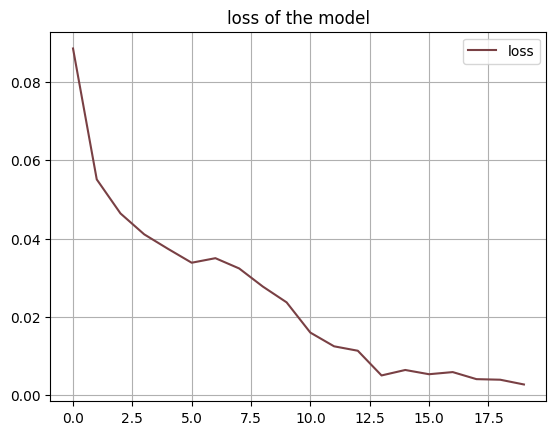

In [24]:
plt.grid(True, which='both')
plt.plot(hist_left['loss_hist'], color='#794044')
plt.title('loss of the model')
plt.legend(['loss'])
plt.savefig('histLoss_of_the_VIT_model.png', transparent=True)
plt.show()

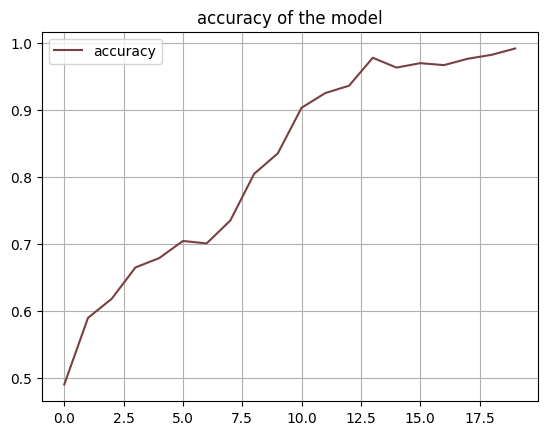

In [25]:
plt.grid(True, which='both')
plt.plot(hist_left['acc_hist'], color='#794044')
plt.legend(['accuracy'])
plt.title('accuracy of the model')
plt.savefig('histAccuracy_of_the_VIT_model.png', transparent=True)
plt.show()

*Image Classification Prediction using Trained Vision Transformer (ViT) Model*

In [26]:
def predict(model, img):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    model.to(device)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5])
        ])

    img = transform(img)
    output = model(img.unsqueeze(0).to(device))
    prediction = output.argmax(dim=1).item()

    return id2label[prediction]

*Test the model on a sample*

In [27]:
print(predict(trained_model_left, dataset_left['test'][10]['image']))

1


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [28]:
dataset_left['test'][10]['label']

1

*Model Evolution*

In [29]:
pred = [int(predict(trained_model_left, dataset_left['test'][i]['image'])) for i in range(0, len(dataset_left['test']))]

In [30]:
actu = [dataset_left['test'][i]['label'] for i in range(0, len(dataset_left['test']))]

In [31]:
len(pred), len(actu)

(204, 204)

In [35]:
from sklearn.metrics import f1_score, matthews_corrcoef, accuracy_score
f1 = f1_score(actu, pred, average='macro')
mcc = matthews_corrcoef(actu, pred)
acc = accuracy_score(actu, pred)

In [36]:
mcc, f1, acc

(0.3365543145838916, 0.5494858400541239, 0.5441176470588235)

In [37]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(confusion_matrix, labels, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="YlGnBu", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(title)
    plt.show()

In [38]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(actu,pred)
cm

array([[32, 34,  2],
       [18, 48,  2],
       [ 6, 31, 31]])

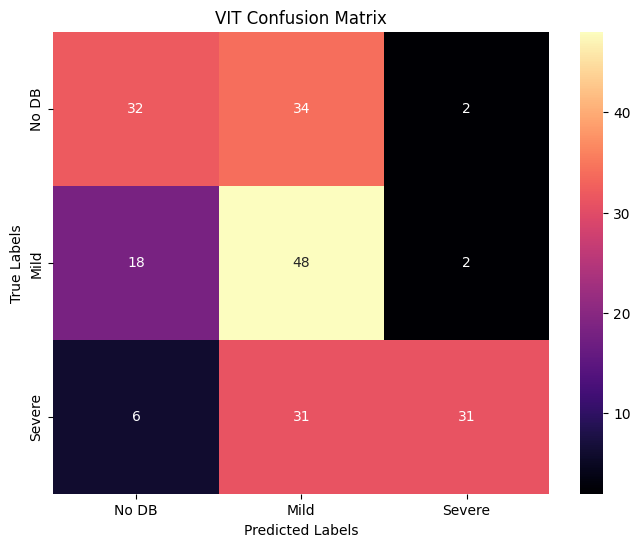

In [44]:
class_labels = ['No DB', 'Mild', 'Severe']

# Assuming you have the confusion matrix stored in a variable called 'cm'

# Create a single subplot
fig, axes = plt.subplots(figsize=(8, 6))

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="magma", xticklabels=class_labels, yticklabels=class_labels, ax=axes)
axes.set_xlabel("Predicted Labels")
axes.set_ylabel("True Labels")
axes.set_title("VIT Confusion Matrix")

plt.savefig('Confusion_Matrix_VIT.png', transparent=True)
plt.show()